# Gensim NMF vs other models

In [1]:
%load_ext line_profiler
%load_ext autoreload

%autoreload 2

from gensim.models.nmf import Nmf as GensimNmf
from gensim.models import CoherenceModel, LdaModel
from gensim.parsing.preprocessing import preprocess_documents
from gensim import matutils
from sklearn.decomposition.nmf import NMF as SklearnNmf
import sklearn.decomposition.nmf
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from matplotlib import pyplot as plt

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# 20newsgroups

In [2]:
categories = [
    'alt.atheism',
    'comp.graphics',
    'rec.motorcycles',
    'talk.politics.mideast',
    'sci.space'
]

trainset = fetch_20newsgroups(subset='train', categories=categories, random_state=42)
testset = fetch_20newsgroups(subset='test', categories=categories, random_state=42)

In [3]:
from gensim.parsing.preprocessing import preprocess_documents

train_documents = preprocess_documents(trainset.data)

In [4]:
from gensim.corpora import Dictionary

dictionary = Dictionary(train_documents)

dictionary.filter_extremes()

2018-09-12 20:53:12,761 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-09-12 20:53:13,091 : INFO : built Dictionary(25279 unique tokens: ['angu', 'bb', 'carri', 'demonstr', 'dragon']...) from 2819 documents (total 435348 corpus positions)
2018-09-12 20:53:13,156 : INFO : discarding 18197 tokens: [('angu', 2), ('edu', 1785), ('line', 2748), ('lussmyer', 1), ('organ', 2602), ('subject', 2819), ('write', 1743), ('absood', 4), ('deragatori', 3), ('indistinct', 3)]...
2018-09-12 20:53:13,157 : INFO : keeping 7082 tokens which were in no less than 5 and no more than 1409 (=50.0%) documents
2018-09-12 20:53:13,165 : INFO : resulting dictionary: Dictionary(7082 unique tokens: ['bb', 'carri', 'demonstr', 'dragon', 'exactli']...)


In [5]:
corpus = [
    dictionary.doc2bow(document)
    for document
    in train_documents
]

bow_matrix = matutils.corpus2dense(corpus, len(dictionary), len(train_documents))
proba_bow_matrix = bow_matrix / bow_matrix.sum(axis=0)

## Gensim NMF vs Gensim LDA

In [20]:
training_params = dict(
    corpus=corpus,
    chunksize=100,
    num_topics=5,
    id2word=dictionary,
    passes=5,
    eval_every=10,
    minimum_probability=0
)

### Training time

In [21]:
%%time

np.random.seed(42)

gensim_nmf = GensimNmf(
    **training_params,
    use_r=True,
    lambda_=10,
)

2018-09-12 20:58:50,218 : INFO : Loss (no outliers): 230.22475241071896	Loss (with outliers): 181.72478704101758
2018-09-12 20:58:51,164 : INFO : Loss (no outliers): 163.48810664663065	Loss (with outliers): 144.25987095642046
2018-09-12 20:58:52,081 : INFO : Loss (no outliers): 159.0804739083802	Loss (with outliers): 146.29286144958536
2018-09-12 20:58:52,988 : INFO : Loss (no outliers): 226.95806797833993	Loss (with outliers): 164.64238869319595
2018-09-12 20:58:53,934 : INFO : Loss (no outliers): 315.60393412205065	Loss (with outliers): 212.8099190508261
2018-09-12 20:58:54,829 : INFO : Loss (no outliers): 273.15289715620474	Loss (with outliers): 209.02117087605416
2018-09-12 20:58:55,760 : INFO : Loss (no outliers): 193.84147325913466	Loss (with outliers): 153.92610633268097
2018-09-12 20:58:56,816 : INFO : Loss (no outliers): 224.72348560200965	Loss (with outliers): 159.7287973966028
2018-09-12 20:58:57,725 : INFO : Loss (no outliers): 141.73839636051133	Loss (with outliers): 137.3

CPU times: user 25.5 s, sys: 29 s, total: 54.5 s
Wall time: 14.1 s


In [22]:
%lprun -f GensimNmf._solveproj GensimNmf(**training_params, use_r=True, lambda_=10)

2018-09-12 20:59:04,192 : INFO : Loss (no outliers): 230.34056054984242	Loss (with outliers): 182.08434566569053
2018-09-12 20:59:05,164 : INFO : Loss (no outliers): 163.71642098551374	Loss (with outliers): 144.36487487868305
2018-09-12 20:59:06,122 : INFO : Loss (no outliers): 160.56477083345212	Loss (with outliers): 147.25872435716468
2018-09-12 20:59:07,112 : INFO : Loss (no outliers): 225.67612281887742	Loss (with outliers): 163.077985626035
2018-09-12 20:59:08,196 : INFO : Loss (no outliers): 316.7881583440518	Loss (with outliers): 213.8086221268407
2018-09-12 20:59:09,173 : INFO : Loss (no outliers): 271.1781810297604	Loss (with outliers): 207.501789900391
2018-09-12 20:59:10,163 : INFO : Loss (no outliers): 194.54551260476714	Loss (with outliers): 154.11575594904286
2018-09-12 20:59:11,168 : INFO : Loss (no outliers): 218.4376400812092	Loss (with outliers): 155.60139243917698
2018-09-12 20:59:12,103 : INFO : Loss (no outliers): 142.12546252260182	Loss (with outliers): 137.745801

In [23]:
%%time

np.random.seed(42)

gensim_lda = LdaModel(**training_params)

2018-09-12 20:59:17,750 : INFO : using symmetric alpha at 0.2
2018-09-12 20:59:17,751 : INFO : using symmetric eta at 0.2
2018-09-12 20:59:17,752 : INFO : using serial LDA version on this node
2018-09-12 20:59:17,758 : INFO : running online (multi-pass) LDA training, 5 topics, 5 passes over the supplied corpus of 2819 documents, updating model once every 100 documents, evaluating perplexity every 1000 documents, iterating 50x with a convergence threshold of 0.001000
2018-09-12 20:59:17,759 : INFO : PROGRESS: pass 0, at document #100/2819
2018-09-12 20:59:17,865 : INFO : merging changes from 100 documents into a model of 2819 documents
2018-09-12 20:59:17,872 : INFO : topic #0 (0.200): 0.007*"com" + 0.007*"jew" + 0.006*"think" + 0.006*"oper" + 0.006*"new" + 0.005*"host" + 0.005*"lunar" + 0.005*"univers" + 0.005*"model" + 0.005*"nntp"
2018-09-12 20:59:17,873 : INFO : topic #1 (0.200): 0.007*"peopl" + 0.006*"univers" + 0.005*"space" + 0.005*"like" + 0.005*"peac" + 0.005*"nasa" + 0.004*"li

2018-09-12 20:59:18,478 : INFO : topic #0 (0.200): 0.011*"imag" + 0.010*"com" + 0.006*"host" + 0.006*"know" + 0.006*"nntp" + 0.006*"like" + 0.006*"think" + 0.006*"file" + 0.005*"need" + 0.005*"alaska"
2018-09-12 20:59:18,478 : INFO : topic #1 (0.200): 0.007*"bike" + 0.007*"like" + 0.007*"nasa" + 0.007*"peopl" + 0.006*"orbit" + 0.006*"com" + 0.006*"thing" + 0.006*"gov" + 0.006*"god" + 0.005*"univers"
2018-09-12 20:59:18,479 : INFO : topic #2 (0.200): 0.012*"isra" + 0.011*"israel" + 0.011*"peopl" + 0.008*"right" + 0.006*"jew" + 0.006*"think" + 0.006*"said" + 0.005*"arab" + 0.005*"men" + 0.005*"kill"
2018-09-12 20:59:18,480 : INFO : topic #3 (0.200): 0.010*"space" + 0.009*"univers" + 0.009*"com" + 0.006*"host" + 0.006*"nntp" + 0.006*"graphic" + 0.005*"new" + 0.004*"know" + 0.004*"like" + 0.004*"program"
2018-09-12 20:59:18,481 : INFO : topic #4 (0.200): 0.017*"armenian" + 0.009*"turkish" + 0.007*"peopl" + 0.006*"like" + 0.005*"know" + 0.005*"com" + 0.005*"time" + 0.005*"greek" + 0.005*"sa

2018-09-12 20:59:19,131 : INFO : topic #3 (0.200): 0.014*"space" + 0.009*"graphic" + 0.006*"pub" + 0.006*"data" + 0.006*"com" + 0.006*"rai" + 0.006*"program" + 0.005*"univers" + 0.005*"new" + 0.005*"point"
2018-09-12 20:59:19,132 : INFO : topic #4 (0.200): 0.019*"armenian" + 0.012*"turkish" + 0.008*"peopl" + 0.007*"greek" + 0.007*"turk" + 0.005*"turkei" + 0.005*"armenia" + 0.005*"like" + 0.004*"org" + 0.004*"time"
2018-09-12 20:59:19,132 : INFO : topic diff=0.403653, rho=0.277350
2018-09-12 20:59:19,133 : INFO : PROGRESS: pass 0, at document #1400/2819
2018-09-12 20:59:19,207 : INFO : merging changes from 100 documents into a model of 2819 documents
2018-09-12 20:59:19,212 : INFO : topic #0 (0.200): 0.015*"imag" + 0.012*"com" + 0.010*"file" + 0.008*"mail" + 0.007*"graphic" + 0.006*"host" + 0.006*"nntp" + 0.006*"us" + 0.006*"format" + 0.006*"send"
2018-09-12 20:59:19,212 : INFO : topic #1 (0.200): 0.010*"com" + 0.009*"bike" + 0.008*"like" + 0.007*"gov" + 0.006*"thing" + 0.006*"nasa" + 0

2018-09-12 20:59:19,720 : INFO : PROGRESS: pass 0, at document #2000/2819
2018-09-12 20:59:19,787 : INFO : merging changes from 100 documents into a model of 2819 documents
2018-09-12 20:59:19,792 : INFO : topic #0 (0.200): 0.020*"imag" + 0.012*"com" + 0.012*"file" + 0.008*"host" + 0.007*"nntp" + 0.006*"univers" + 0.006*"graphic" + 0.006*"know" + 0.006*"need" + 0.006*"bit"
2018-09-12 20:59:19,793 : INFO : topic #1 (0.200): 0.012*"com" + 0.009*"bike" + 0.008*"like" + 0.006*"nasa" + 0.006*"thing" + 0.005*"time" + 0.005*"gov" + 0.005*"know" + 0.005*"think" + 0.005*"dod"
2018-09-12 20:59:19,794 : INFO : topic #2 (0.200): 0.011*"peopl" + 0.010*"israel" + 0.008*"isra" + 0.008*"think" + 0.007*"jew" + 0.006*"god" + 0.006*"right" + 0.005*"arab" + 0.005*"state" + 0.005*"moral"
2018-09-12 20:59:19,795 : INFO : topic #3 (0.200): 0.018*"space" + 0.008*"nasa" + 0.007*"data" + 0.007*"program" + 0.006*"univers" + 0.005*"orbit" + 0.005*"com" + 0.005*"graphic" + 0.005*"satellit" + 0.005*"center"
2018-09

2018-09-12 20:59:20,219 : INFO : topic #3 (0.200): 0.020*"space" + 0.010*"launch" + 0.008*"nasa" + 0.008*"satellit" + 0.006*"program" + 0.006*"data" + 0.006*"new" + 0.005*"orbit" + 0.005*"inform" + 0.005*"com"
2018-09-12 20:59:20,219 : INFO : topic #4 (0.200): 0.021*"armenian" + 0.013*"turkish" + 0.009*"peopl" + 0.007*"said" + 0.006*"turkei" + 0.006*"armenia" + 0.005*"time" + 0.005*"know" + 0.005*"turk" + 0.004*"soviet"
2018-09-12 20:59:20,220 : INFO : topic diff=0.243524, rho=0.196116
2018-09-12 20:59:20,220 : INFO : PROGRESS: pass 0, at document #2700/2819
2018-09-12 20:59:20,276 : INFO : merging changes from 100 documents into a model of 2819 documents
2018-09-12 20:59:20,281 : INFO : topic #0 (0.200): 0.017*"imag" + 0.015*"file" + 0.012*"com" + 0.008*"jpeg" + 0.007*"need" + 0.007*"color" + 0.007*"host" + 0.007*"nntp" + 0.007*"gif" + 0.006*"us"
2018-09-12 20:59:20,281 : INFO : topic #1 (0.200): 0.014*"com" + 0.009*"like" + 0.008*"bike" + 0.006*"know" + 0.005*"thing" + 0.005*"nntp" +

2018-09-12 20:59:20,613 : INFO : topic diff=0.158672, rho=0.181999
2018-09-12 20:59:20,614 : INFO : PROGRESS: pass 1, at document #400/2819
2018-09-12 20:59:20,670 : INFO : merging changes from 100 documents into a model of 2819 documents
2018-09-12 20:59:20,675 : INFO : topic #0 (0.200): 0.014*"file" + 0.013*"com" + 0.012*"imag" + 0.009*"host" + 0.009*"nntp" + 0.009*"access" + 0.008*"need" + 0.007*"thank" + 0.007*"graphic" + 0.006*"us"
2018-09-12 20:59:20,676 : INFO : topic #1 (0.200): 0.012*"com" + 0.010*"dod" + 0.009*"bike" + 0.009*"like" + 0.006*"host" + 0.006*"nntp" + 0.006*"ride" + 0.005*"thing" + 0.005*"know" + 0.005*"motorcycl"
2018-09-12 20:59:20,677 : INFO : topic #2 (0.200): 0.012*"god" + 0.009*"israel" + 0.009*"peopl" + 0.008*"isra" + 0.007*"think" + 0.007*"believ" + 0.006*"islam" + 0.006*"exist" + 0.006*"state" + 0.006*"jew"
2018-09-12 20:59:20,678 : INFO : topic #3 (0.200): 0.015*"space" + 0.007*"univers" + 0.006*"new" + 0.006*"nasa" + 0.005*"inform" + 0.004*"orbit" + 0.0

2018-09-12 20:59:21,195 : INFO : topic #2 (0.200): 0.010*"israel" + 0.009*"peopl" + 0.009*"isra" + 0.009*"god" + 0.007*"believ" + 0.007*"right" + 0.007*"atheist" + 0.006*"arab" + 0.006*"think" + 0.006*"state"
2018-09-12 20:59:21,196 : INFO : topic #3 (0.200): 0.019*"space" + 0.008*"orbit" + 0.007*"nasa" + 0.006*"new" + 0.006*"mission" + 0.006*"univers" + 0.006*"point" + 0.005*"launch" + 0.005*"probe" + 0.005*"year"
2018-09-12 20:59:21,197 : INFO : topic #4 (0.200): 0.017*"armenian" + 0.010*"turkish" + 0.010*"peopl" + 0.009*"said" + 0.008*"greek" + 0.006*"turk" + 0.005*"know" + 0.004*"time" + 0.004*"kill" + 0.004*"armenia"
2018-09-12 20:59:21,198 : INFO : topic diff=0.191512, rho=0.181999
2018-09-12 20:59:21,198 : INFO : PROGRESS: pass 1, at document #1100/2819
2018-09-12 20:59:21,253 : INFO : merging changes from 100 documents into a model of 2819 documents
2018-09-12 20:59:21,258 : INFO : topic #0 (0.200): 0.017*"imag" + 0.013*"com" + 0.013*"file" + 0.009*"graphic" + 0.008*"host" + 0.

2018-09-12 20:59:21,579 : INFO : topic diff=0.130285, rho=0.181999
2018-09-12 20:59:21,580 : INFO : PROGRESS: pass 1, at document #1700/2819
2018-09-12 20:59:21,631 : INFO : merging changes from 100 documents into a model of 2819 documents
2018-09-12 20:59:21,635 : INFO : topic #0 (0.200): 0.022*"imag" + 0.013*"file" + 0.012*"graphic" + 0.012*"com" + 0.008*"host" + 0.008*"program" + 0.007*"nntp" + 0.007*"bit" + 0.007*"us" + 0.007*"thank"
2018-09-12 20:59:21,636 : INFO : topic #1 (0.200): 0.014*"com" + 0.009*"like" + 0.009*"bike" + 0.006*"thing" + 0.006*"nntp" + 0.005*"host" + 0.005*"time" + 0.005*"ride" + 0.005*"know" + 0.005*"dod"
2018-09-12 20:59:21,637 : INFO : topic #2 (0.200): 0.010*"peopl" + 0.009*"israel" + 0.008*"think" + 0.007*"isra" + 0.007*"god" + 0.006*"right" + 0.006*"state" + 0.005*"arab" + 0.005*"jew" + 0.005*"christian"
2018-09-12 20:59:21,637 : INFO : topic #3 (0.200): 0.015*"space" + 0.008*"nasa" + 0.006*"orbit" + 0.006*"data" + 0.005*"univers" + 0.005*"new" + 0.005*"

2018-09-12 20:59:22,130 : INFO : topic #1 (0.200): 0.015*"com" + 0.010*"like" + 0.008*"bike" + 0.006*"think" + 0.006*"thing" + 0.006*"nntp" + 0.006*"know" + 0.006*"host" + 0.005*"gov" + 0.005*"dod"
2018-09-12 20:59:22,131 : INFO : topic #2 (0.200): 0.011*"peopl" + 0.008*"israel" + 0.008*"isra" + 0.008*"think" + 0.007*"god" + 0.006*"right" + 0.006*"jew" + 0.005*"islam" + 0.005*"arab" + 0.005*"human"
2018-09-12 20:59:22,131 : INFO : topic #3 (0.200): 0.017*"space" + 0.010*"nasa" + 0.007*"orbit" + 0.006*"data" + 0.005*"point" + 0.005*"new" + 0.005*"univers" + 0.004*"softwar" + 0.004*"scienc" + 0.004*"inform"
2018-09-12 20:59:22,132 : INFO : topic #4 (0.200): 0.018*"armenian" + 0.012*"peopl" + 0.008*"turkish" + 0.008*"said" + 0.007*"armenia" + 0.005*"turk" + 0.005*"know" + 0.005*"time" + 0.005*"come" + 0.005*"live"
2018-09-12 20:59:22,133 : INFO : topic diff=0.149647, rho=0.181999
2018-09-12 20:59:22,133 : INFO : PROGRESS: pass 1, at document #2400/2819
2018-09-12 20:59:22,184 : INFO : mer

2018-09-12 20:59:22,504 : INFO : topic #4 (0.200): 0.018*"armenian" + 0.010*"peopl" + 0.010*"turkish" + 0.008*"said" + 0.006*"armenia" + 0.005*"compromis" + 0.005*"turkei" + 0.005*"know" + 0.005*"soviet" + 0.005*"turk"
2018-09-12 20:59:22,504 : INFO : topic diff=0.228487, rho=0.181999
2018-09-12 20:59:22,505 : INFO : PROGRESS: pass 2, at document #100/2819
2018-09-12 20:59:22,561 : INFO : merging changes from 100 documents into a model of 2819 documents
2018-09-12 20:59:22,566 : INFO : topic #0 (0.200): 0.017*"file" + 0.013*"imag" + 0.011*"com" + 0.010*"graphic" + 0.008*"program" + 0.008*"need" + 0.008*"host" + 0.008*"nntp" + 0.007*"version" + 0.007*"thank"
2018-09-12 20:59:22,566 : INFO : topic #1 (0.200): 0.014*"com" + 0.009*"like" + 0.007*"bike" + 0.006*"nntp" + 0.006*"host" + 0.006*"know" + 0.005*"dod" + 0.005*"thing" + 0.005*"think" + 0.004*"good"
2018-09-12 20:59:22,567 : INFO : topic #2 (0.200): 0.013*"god" + 0.010*"israel" + 0.009*"peopl" + 0.008*"believ" + 0.008*"isra" + 0.007

2018-09-12 20:59:22,946 : INFO : topic #1 (0.200): 0.014*"com" + 0.010*"like" + 0.009*"bike" + 0.007*"dod" + 0.007*"host" + 0.007*"nntp" + 0.006*"thing" + 0.005*"know" + 0.005*"think" + 0.005*"ride"
2018-09-12 20:59:22,947 : INFO : topic #2 (0.200): 0.011*"god" + 0.010*"israel" + 0.009*"peopl" + 0.009*"isra" + 0.007*"think" + 0.006*"believ" + 0.006*"jew" + 0.006*"islam" + 0.005*"right" + 0.005*"state"
2018-09-12 20:59:22,948 : INFO : topic #3 (0.200): 0.018*"space" + 0.008*"nasa" + 0.007*"orbit" + 0.007*"univers" + 0.006*"launch" + 0.006*"new" + 0.005*"inform" + 0.005*"scienc" + 0.005*"year" + 0.004*"earth"
2018-09-12 20:59:22,948 : INFO : topic #4 (0.200): 0.018*"armenian" + 0.011*"peopl" + 0.011*"said" + 0.010*"turkish" + 0.006*"kill" + 0.006*"know" + 0.005*"went" + 0.005*"greek" + 0.005*"turk" + 0.005*"time"
2018-09-12 20:59:22,949 : INFO : topic diff=0.130615, rho=0.179057
2018-09-12 20:59:22,949 : INFO : PROGRESS: pass 2, at document #800/2819
2018-09-12 20:59:23,003 : INFO : merg

2018-09-12 20:59:23,455 : INFO : topic #3 (0.200): 0.018*"space" + 0.009*"nasa" + 0.007*"orbit" + 0.006*"new" + 0.005*"data" + 0.005*"point" + 0.005*"center" + 0.005*"univers" + 0.005*"mission" + 0.004*"launch"
2018-09-12 20:59:23,455 : INFO : topic #4 (0.200): 0.021*"armenian" + 0.012*"turkish" + 0.011*"peopl" + 0.008*"greek" + 0.007*"said" + 0.007*"turk" + 0.005*"turkei" + 0.005*"armenia" + 0.005*"soviet" + 0.004*"know"
2018-09-12 20:59:23,456 : INFO : topic diff=0.174433, rho=0.179057
2018-09-12 20:59:23,456 : INFO : PROGRESS: pass 2, at document #1400/2819
2018-09-12 20:59:23,513 : INFO : merging changes from 100 documents into a model of 2819 documents
2018-09-12 20:59:23,517 : INFO : topic #0 (0.200): 0.016*"graphic" + 0.016*"imag" + 0.013*"file" + 0.012*"com" + 0.008*"mail" + 0.008*"program" + 0.008*"host" + 0.007*"pub" + 0.007*"us" + 0.007*"format"
2018-09-12 20:59:23,518 : INFO : topic #1 (0.200): 0.016*"com" + 0.010*"bike" + 0.009*"like" + 0.006*"nntp" + 0.006*"host" + 0.006*

2018-09-12 20:59:23,939 : INFO : PROGRESS: pass 2, at document #2000/2819
2018-09-12 20:59:23,991 : INFO : merging changes from 100 documents into a model of 2819 documents
2018-09-12 20:59:23,996 : INFO : topic #0 (0.200): 0.020*"imag" + 0.013*"graphic" + 0.013*"file" + 0.011*"com" + 0.009*"program" + 0.008*"ftp" + 0.008*"host" + 0.008*"univers" + 0.008*"nntp" + 0.007*"us"
2018-09-12 20:59:23,997 : INFO : topic #1 (0.200): 0.016*"com" + 0.009*"like" + 0.009*"bike" + 0.006*"think" + 0.006*"nntp" + 0.006*"know" + 0.006*"host" + 0.006*"thing" + 0.005*"dod" + 0.005*"good"
2018-09-12 20:59:23,998 : INFO : topic #2 (0.200): 0.010*"peopl" + 0.009*"israel" + 0.008*"think" + 0.008*"isra" + 0.008*"god" + 0.006*"jew" + 0.005*"right" + 0.005*"arab" + 0.005*"state" + 0.005*"believ"
2018-09-12 20:59:23,999 : INFO : topic #3 (0.200): 0.020*"space" + 0.013*"nasa" + 0.008*"orbit" + 0.006*"data" + 0.005*"center" + 0.005*"new" + 0.005*"univers" + 0.005*"launch" + 0.005*"research" + 0.005*"satellit"
2018

2018-09-12 20:59:24,365 : INFO : topic #2 (0.200): 0.010*"god" + 0.010*"jew" + 0.009*"peopl" + 0.008*"israel" + 0.007*"isra" + 0.007*"think" + 0.006*"exist" + 0.006*"right" + 0.005*"believ" + 0.005*"know"
2018-09-12 20:59:24,365 : INFO : topic #3 (0.200): 0.021*"space" + 0.012*"launch" + 0.011*"nasa" + 0.008*"satellit" + 0.007*"orbit" + 0.006*"new" + 0.005*"data" + 0.005*"year" + 0.005*"inform" + 0.005*"center"
2018-09-12 20:59:24,366 : INFO : topic #4 (0.200): 0.022*"armenian" + 0.013*"turkish" + 0.011*"peopl" + 0.008*"said" + 0.007*"armenia" + 0.007*"turkei" + 0.006*"know" + 0.005*"time" + 0.005*"turk" + 0.005*"soviet"
2018-09-12 20:59:24,367 : INFO : topic diff=0.166120, rho=0.179057
2018-09-12 20:59:24,367 : INFO : PROGRESS: pass 2, at document #2700/2819
2018-09-12 20:59:24,422 : INFO : merging changes from 100 documents into a model of 2819 documents
2018-09-12 20:59:24,427 : INFO : topic #0 (0.200): 0.017*"imag" + 0.015*"file" + 0.011*"com" + 0.010*"graphic" + 0.008*"jpeg" + 0.0

2018-09-12 20:59:24,728 : INFO : topic #4 (0.200): 0.016*"armenian" + 0.010*"said" + 0.010*"turkish" + 0.009*"peopl" + 0.005*"turkei" + 0.005*"armenia" + 0.005*"turk" + 0.005*"sai" + 0.005*"kill" + 0.005*"greek"
2018-09-12 20:59:24,728 : INFO : topic diff=0.124056, rho=0.176254
2018-09-12 20:59:24,729 : INFO : PROGRESS: pass 3, at document #400/2819
2018-09-12 20:59:24,777 : INFO : merging changes from 100 documents into a model of 2819 documents
2018-09-12 20:59:24,784 : INFO : topic #0 (0.200): 0.015*"file" + 0.012*"imag" + 0.012*"com" + 0.011*"graphic" + 0.009*"host" + 0.009*"need" + 0.008*"nntp" + 0.008*"thank" + 0.007*"access" + 0.007*"program"
2018-09-12 20:59:24,785 : INFO : topic #1 (0.200): 0.014*"com" + 0.010*"like" + 0.009*"dod" + 0.009*"bike" + 0.007*"host" + 0.007*"nntp" + 0.006*"ride" + 0.005*"know" + 0.005*"think" + 0.005*"thing"
2018-09-12 20:59:24,786 : INFO : topic #2 (0.200): 0.012*"god" + 0.009*"israel" + 0.008*"peopl" + 0.008*"isra" + 0.007*"think" + 0.007*"believ"

2018-09-12 20:59:25,271 : INFO : topic #0 (0.200): 0.016*"imag" + 0.013*"file" + 0.012*"com" + 0.009*"host" + 0.009*"graphic" + 0.009*"nntp" + 0.008*"program" + 0.008*"univers" + 0.008*"thank" + 0.007*"need"
2018-09-12 20:59:25,271 : INFO : topic #1 (0.200): 0.015*"com" + 0.010*"bike" + 0.009*"like" + 0.007*"ride" + 0.006*"dod" + 0.006*"host" + 0.006*"nntp" + 0.006*"know" + 0.006*"thing" + 0.005*"think"
2018-09-12 20:59:25,272 : INFO : topic #2 (0.200): 0.010*"israel" + 0.009*"peopl" + 0.009*"god" + 0.009*"isra" + 0.007*"believ" + 0.006*"atheist" + 0.006*"right" + 0.006*"think" + 0.006*"arab" + 0.006*"state"
2018-09-12 20:59:25,273 : INFO : topic #3 (0.200): 0.020*"space" + 0.009*"orbit" + 0.008*"nasa" + 0.007*"new" + 0.007*"launch" + 0.006*"mission" + 0.006*"year" + 0.005*"probe" + 0.005*"point" + 0.005*"univers"
2018-09-12 20:59:25,274 : INFO : topic #4 (0.200): 0.018*"armenian" + 0.011*"peopl" + 0.011*"turkish" + 0.009*"said" + 0.008*"greek" + 0.006*"turk" + 0.005*"kill" + 0.005*"kn

2018-09-12 20:59:25,633 : INFO : topic #3 (0.200): 0.016*"space" + 0.009*"nasa" + 0.006*"orbit" + 0.006*"new" + 0.005*"point" + 0.005*"center" + 0.005*"research" + 0.005*"univers" + 0.004*"scienc" + 0.004*"data"
2018-09-12 20:59:25,634 : INFO : topic #4 (0.200): 0.020*"armenian" + 0.010*"peopl" + 0.010*"turkish" + 0.008*"said" + 0.007*"armenia" + 0.007*"turk" + 0.006*"turkei" + 0.006*"greek" + 0.005*"time" + 0.004*"kill"
2018-09-12 20:59:25,634 : INFO : topic diff=0.108742, rho=0.176254
2018-09-12 20:59:25,635 : INFO : PROGRESS: pass 3, at document #1700/2819
2018-09-12 20:59:25,684 : INFO : merging changes from 100 documents into a model of 2819 documents
2018-09-12 20:59:25,689 : INFO : topic #0 (0.200): 0.021*"imag" + 0.014*"graphic" + 0.013*"file" + 0.011*"com" + 0.009*"program" + 0.008*"host" + 0.007*"nntp" + 0.007*"mail" + 0.007*"us" + 0.007*"univers"
2018-09-12 20:59:25,690 : INFO : topic #1 (0.200): 0.016*"com" + 0.010*"like" + 0.009*"bike" + 0.006*"nntp" + 0.006*"host" + 0.006

2018-09-12 20:59:26,110 : INFO : topic diff=0.146208, rho=0.176254
2018-09-12 20:59:26,111 : INFO : PROGRESS: pass 3, at document #2300/2819
2018-09-12 20:59:26,165 : INFO : merging changes from 100 documents into a model of 2819 documents
2018-09-12 20:59:26,170 : INFO : topic #0 (0.200): 0.023*"imag" + 0.017*"file" + 0.014*"jpeg" + 0.012*"graphic" + 0.010*"gif" + 0.010*"format" + 0.010*"color" + 0.009*"program" + 0.008*"com" + 0.008*"us"
2018-09-12 20:59:26,170 : INFO : topic #1 (0.200): 0.017*"com" + 0.010*"like" + 0.008*"bike" + 0.007*"think" + 0.006*"nntp" + 0.006*"know" + 0.006*"thing" + 0.006*"host" + 0.005*"look" + 0.005*"good"
2018-09-12 20:59:26,171 : INFO : topic #2 (0.200): 0.011*"peopl" + 0.008*"israel" + 0.008*"isra" + 0.007*"think" + 0.007*"god" + 0.006*"right" + 0.006*"jew" + 0.005*"islam" + 0.005*"arab" + 0.005*"human"
2018-09-12 20:59:26,172 : INFO : topic #3 (0.200): 0.019*"space" + 0.012*"nasa" + 0.008*"orbit" + 0.005*"new" + 0.005*"launch" + 0.005*"point" + 0.005*"

2018-09-12 20:59:26,526 : INFO : topic #1 (0.200): 0.015*"com" + 0.010*"like" + 0.007*"bike" + 0.007*"know" + 0.006*"nntp" + 0.006*"host" + 0.005*"think" + 0.005*"thing" + 0.005*"dod" + 0.005*"einstein"
2018-09-12 20:59:26,527 : INFO : topic #2 (0.200): 0.014*"god" + 0.009*"israel" + 0.009*"peopl" + 0.008*"believ" + 0.007*"atheist" + 0.007*"isra" + 0.007*"think" + 0.007*"exist" + 0.006*"islam" + 0.005*"state"
2018-09-12 20:59:26,528 : INFO : topic #3 (0.200): 0.022*"space" + 0.010*"nasa" + 0.008*"launch" + 0.007*"inform" + 0.006*"new" + 0.006*"satellit" + 0.005*"orbit" + 0.005*"design" + 0.005*"scienc" + 0.005*"univers"
2018-09-12 20:59:26,529 : INFO : topic #4 (0.200): 0.019*"armenian" + 0.010*"peopl" + 0.010*"turkish" + 0.008*"said" + 0.006*"armenia" + 0.005*"compromis" + 0.005*"turkei" + 0.005*"turk" + 0.005*"soviet" + 0.005*"know"
2018-09-12 20:59:26,529 : INFO : topic diff=0.205506, rho=0.176254
2018-09-12 20:59:26,530 : INFO : PROGRESS: pass 4, at document #100/2819
2018-09-12 20

2018-09-12 20:59:26,879 : INFO : topic #4 (0.200): 0.019*"armenian" + 0.012*"said" + 0.012*"peopl" + 0.010*"turkish" + 0.006*"kill" + 0.006*"know" + 0.005*"greek" + 0.005*"went" + 0.005*"turk" + 0.005*"children"
2018-09-12 20:59:26,880 : INFO : topic diff=0.107799, rho=0.173579
2018-09-12 20:59:26,880 : INFO : PROGRESS: pass 4, at document #700/2819
2018-09-12 20:59:26,937 : INFO : merging changes from 100 documents into a model of 2819 documents
2018-09-12 20:59:26,942 : INFO : topic #0 (0.200): 0.016*"file" + 0.015*"imag" + 0.012*"com" + 0.011*"graphic" + 0.010*"host" + 0.009*"nntp" + 0.008*"univers" + 0.008*"need" + 0.007*"us" + 0.007*"thank"
2018-09-12 20:59:26,943 : INFO : topic #1 (0.200): 0.015*"com" + 0.010*"like" + 0.009*"bike" + 0.007*"dod" + 0.007*"host" + 0.007*"nntp" + 0.006*"think" + 0.006*"know" + 0.006*"thing" + 0.005*"ride"
2018-09-12 20:59:26,944 : INFO : topic #2 (0.200): 0.011*"god" + 0.010*"israel" + 0.009*"peopl" + 0.009*"isra" + 0.007*"think" + 0.006*"believ" + 0

2018-09-12 20:59:27,429 : INFO : topic #0 (0.200): 0.017*"graphic" + 0.016*"imag" + 0.013*"file" + 0.010*"com" + 0.009*"mail" + 0.008*"pub" + 0.008*"format" + 0.008*"program" + 0.008*"ftp" + 0.007*"host"
2018-09-12 20:59:27,430 : INFO : topic #1 (0.200): 0.016*"com" + 0.010*"bike" + 0.010*"like" + 0.006*"nntp" + 0.006*"host" + 0.006*"thing" + 0.006*"know" + 0.005*"think" + 0.005*"ride" + 0.005*"dod"
2018-09-12 20:59:27,431 : INFO : topic #2 (0.200): 0.011*"god" + 0.009*"peopl" + 0.009*"israel" + 0.008*"isra" + 0.007*"think" + 0.006*"believ" + 0.006*"exist" + 0.006*"atheist" + 0.006*"arab" + 0.005*"right"
2018-09-12 20:59:27,432 : INFO : topic #3 (0.200): 0.019*"space" + 0.010*"nasa" + 0.007*"orbit" + 0.006*"new" + 0.005*"year" + 0.005*"launch" + 0.005*"center" + 0.005*"point" + 0.005*"mission" + 0.005*"earth"
2018-09-12 20:59:27,432 : INFO : topic #4 (0.200): 0.022*"armenian" + 0.013*"turkish" + 0.011*"peopl" + 0.008*"greek" + 0.008*"said" + 0.007*"turk" + 0.005*"turkei" + 0.005*"armen

2018-09-12 20:59:27,785 : INFO : topic #3 (0.200): 0.018*"space" + 0.012*"nasa" + 0.007*"orbit" + 0.006*"new" + 0.005*"point" + 0.005*"univers" + 0.005*"center" + 0.005*"year" + 0.005*"research" + 0.005*"earth"
2018-09-12 20:59:27,785 : INFO : topic #4 (0.200): 0.020*"armenian" + 0.012*"turkish" + 0.010*"peopl" + 0.007*"armenia" + 0.006*"turk" + 0.006*"genocid" + 0.006*"said" + 0.006*"serdar" + 0.006*"soviet" + 0.006*"argic"
2018-09-12 20:59:27,786 : INFO : topic diff=0.112068, rho=0.173579
2018-09-12 20:59:27,900 : INFO : -7.820 per-word bound, 225.9 perplexity estimate based on a held-out corpus of 100 documents with 11906 words
2018-09-12 20:59:27,900 : INFO : PROGRESS: pass 4, at document #2000/2819
2018-09-12 20:59:27,954 : INFO : merging changes from 100 documents into a model of 2819 documents
2018-09-12 20:59:27,959 : INFO : topic #0 (0.200): 0.020*"imag" + 0.014*"graphic" + 0.013*"file" + 0.010*"com" + 0.009*"program" + 0.008*"univers" + 0.008*"ftp" + 0.008*"host" + 0.007*"nnt

2018-09-12 20:59:28,253 : INFO : topic diff=0.112645, rho=0.173579
2018-09-12 20:59:28,253 : INFO : PROGRESS: pass 4, at document #2600/2819
2018-09-12 20:59:28,302 : INFO : merging changes from 100 documents into a model of 2819 documents
2018-09-12 20:59:28,307 : INFO : topic #0 (0.200): 0.018*"imag" + 0.016*"file" + 0.011*"graphic" + 0.010*"com" + 0.009*"jpeg" + 0.008*"program" + 0.008*"color" + 0.007*"format" + 0.007*"gif" + 0.007*"us"
2018-09-12 20:59:28,307 : INFO : topic #1 (0.200): 0.018*"com" + 0.010*"like" + 0.008*"bike" + 0.007*"know" + 0.006*"nntp" + 0.006*"host" + 0.006*"think" + 0.006*"thing" + 0.005*"ride" + 0.005*"look"
2018-09-12 20:59:28,308 : INFO : topic #2 (0.200): 0.010*"god" + 0.010*"jew" + 0.009*"peopl" + 0.008*"israel" + 0.007*"isra" + 0.007*"think" + 0.006*"exist" + 0.006*"right" + 0.005*"believ" + 0.005*"know"
2018-09-12 20:59:28,309 : INFO : topic #3 (0.200): 0.022*"space" + 0.012*"launch" + 0.011*"nasa" + 0.008*"satellit" + 0.007*"orbit" + 0.006*"new" + 0.0

CPU times: user 10.8 s, sys: 676 ms, total: 11.4 s
Wall time: 10.7 s


### Coherence

In [24]:
gensim_nmf_cm = CoherenceModel(
    model=gensim_nmf,
    corpus=corpus,
    coherence='u_mass'
)

gensim_nmf_cm.get_coherence()

2018-09-12 20:59:28,530 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-09-12 20:59:28,549 : INFO : CorpusAccumulator accumulated stats from 2000 documents


-1.8725255613516496

In [25]:
gensim_lda_cm = CoherenceModel(
    model=gensim_lda,
    corpus=corpus,
    coherence='u_mass'
)

gensim_lda_cm.get_coherence()

2018-09-12 20:59:28,613 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-09-12 20:59:28,633 : INFO : CorpusAccumulator accumulated stats from 2000 documents


-1.7277803594076822

### Perplexity

In [26]:
def perplexity(model, corpus):
    W = gensim_nmf.get_topics().T

    H = np.zeros((W.shape[1], len(corpus)))
    for bow_id, bow in enumerate(corpus):
        for topic_id, proba in model[bow]:
            H[topic_id, bow_id] = proba
    
    dense_corpus = matutils.corpus2dense(corpus, W.shape[0])
    
    return np.exp(-(np.log(W.dot(H), where=W.dot(H)>0) * dense_corpus).sum() / dense_corpus.sum())

In [27]:
perplexity(gensim_nmf, corpus)

55656.79384893339

In [28]:
perplexity(gensim_lda, corpus)

103360.93300773863

### Topics

In [18]:
gensim_nmf.show_topics()

[(0,
  '0.031*"armenian" + 0.013*"turkish" + 0.008*"peopl" + 0.007*"armenia" + 0.007*"turk" + 0.006*"govern" + 0.006*"turkei" + 0.006*"world" + 0.006*"russian" + 0.005*"villag"'),
 (1,
  '0.017*"peopl" + 0.016*"said" + 0.015*"know" + 0.010*"like" + 0.009*"sai" + 0.009*"come" + 0.008*"went" + 0.008*"time" + 0.008*"look" + 0.007*"go"'),
 (2,
  '0.019*"god" + 0.011*"exist" + 0.010*"believ" + 0.007*"atheist" + 0.007*"christian" + 0.007*"atheism" + 0.007*"argument" + 0.006*"peopl" + 0.006*"religion" + 0.006*"evid"'),
 (3,
  '0.035*"jpeg" + 0.023*"imag" + 0.013*"file" + 0.011*"program" + 0.011*"format" + 0.009*"us" + 0.009*"softwar" + 0.009*"displai" + 0.009*"avail" + 0.007*"set"'),
 (4,
  '0.027*"space" + 0.011*"nasa" + 0.008*"satellit" + 0.008*"launch" + 0.007*"orbit" + 0.005*"mission" + 0.005*"new" + 0.005*"data" + 0.005*"technolog" + 0.005*"shuttl"')]

In [19]:
gensim_lda.show_topics()

[(0,
  '0.015*"imag" + 0.011*"file" + 0.010*"graphic" + 0.007*"program" + 0.007*"jpeg" + 0.006*"univers" + 0.006*"us" + 0.006*"com" + 0.006*"color" + 0.006*"format"'),
 (1,
  '0.014*"space" + 0.012*"nasa" + 0.008*"orbit" + 0.006*"gov" + 0.006*"launch" + 0.006*"earth" + 0.005*"year" + 0.005*"like" + 0.005*"moon" + 0.005*"new"'),
 (2,
  '0.010*"israel" + 0.009*"god" + 0.008*"isra" + 0.008*"peopl" + 0.006*"think" + 0.006*"jew" + 0.005*"arab" + 0.005*"com" + 0.005*"right" + 0.005*"exist"'),
 (3,
  '0.015*"com" + 0.010*"space" + 0.008*"bike" + 0.005*"dod" + 0.005*"like" + 0.005*"host" + 0.005*"nntp" + 0.005*"ride" + 0.004*"new" + 0.004*"time"'),
 (4,
  '0.018*"armenian" + 0.011*"peopl" + 0.010*"turkish" + 0.007*"said" + 0.006*"know" + 0.005*"armenia" + 0.005*"turkei" + 0.005*"time" + 0.005*"turk" + 0.004*"like"')]

## Gensim NMF vs Sklearn NMF

In [138]:
W = gensim_nmf.get_topics().T
H = np.zeros((W.shape[1], len(corpus)))
for bow_id, bow in enumerate(corpus):
    for topic_id, proba in gensim_nmf[bow]:
        H[topic_id, bow_id] = proba

In [139]:
np.linalg.norm(proba_bow_matrix - W.dot(H), 'fro')

8.563342468627981

In [142]:
%%time

sklearn_nmf = SklearnNmf(n_components=5, tol=1e-5, max_iter=int(1e9), random_state=42)

W = sklearn_nmf.fit_transform(proba_bow_matrix)
H = sklearn_nmf.components_

CPU times: user 31 s, sys: 7.28 s, total: 38.3 s
Wall time: 11.5 s


In [143]:
np.linalg.norm(proba_bow_matrix - W.dot(H), 'fro')

8.300690481807766

## Sklearn wrapper

In [158]:
from sklearn.base import BaseEstimator, TransformerMixin

class NmfWrapper(BaseEstimator, TransformerMixin):
    def __init__(self, **kwargs):
        self.nmf = GensimNmf(**kwargs)
        self.corpus = None
        
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)
    
    def fit(self, X):
        self.corpus = [
            [
                (feature_idx, value)
                for feature_idx, value
                in enumerate(sample)
            ]
            for sample
            in X
        ]
        
        self.nmf.update(self.corpus)
        
    def transform(self, X):
        H = np.zeros((len(self.corpus), self.nmf.num_topics))
        for bow_id, bow in enumerate(self.corpus):
            for topic_id, proba in self.nmf[bow]:
                H[bow_id, topic_id] = proba
                
        return H
        
    @property
    def components_(self):
        return self.nmf.get_topics()

{'data': ['From: John Lussmyer <dragon@angus.mi.org>\nSubject: Re: DC-X update???\nOrganization: Mystery Spot BBS\nReply-To: dragon@angus.mi.org\nLines: 12\n\nhenry@zoo.toronto.edu (Henry Spencer) writes:\n\n> The first flight will be a low hover that will demonstrate a vertical\n> landing.  There will be no payload.  DC-X will never carry any kind\n\nExactly when will the hover test be done, and will any of the TV\nnetworks carry it.  I really want to see that...\n\n--\nJohn Lussmyer (dragon@angus.mi.org)\nMystery Spot BBS, Royal Oak, MI --------------------------------------------?--\n\n',
  'From: jaa12@cunixa.cc.columbia.edu (John A Absood)\nSubject: Re: Freedom In U.S.A.\nNntp-Posting-Host: cunixa.cc.columbia.edu\nReply-To: jaa12@cunixa.cc.columbia.edu (John A Absood)\nOrganization: Columbia University\nLines: 25\n\nDear Mr. Beyer:\n\nIt is never wise to confuse "freedom of speech" with "freedom"\nof racism and violent deragatory."\n\nIt is unfortunate that many fail to understand

## Olivietti faces + Gensim NMF


Faces dataset decompositions

This example applies to :ref:`olivetti_faces` different unsupervised
matrix decomposition (dimension reduction) methods from the module
:py:mod:`sklearn.decomposition` (see the documentation chapter
:ref:`decompositions`) .


Dataset consists of 400 faces
Extracting the top 6 Eigenfaces - PCA using randomized SVD...
done in 0.230s
Extracting the top 6 Non-negative components - NMF (Sklearn)...
done in 0.714s
Extracting the top 6 Non-negative components - NMF (Gensim)...


2018-08-28 15:39:16,302 : INFO : Loss (no outliers): 16.889347578653574	Loss (with outliers): 16.889347578653574
2018-08-28 15:39:17,013 : INFO : Loss (no outliers): 15.896337161780403	Loss (with outliers): 15.896337161780403
2018-08-28 15:39:17,629 : INFO : Loss (no outliers): 16.21949193338844	Loss (with outliers): 16.21949193338844
2018-08-28 15:39:18,217 : INFO : Loss (no outliers): 16.521323059368406	Loss (with outliers): 16.521323059368406
2018-08-28 15:39:18,219 : INFO : Loss (no outliers): 16.521323059368406	Loss (with outliers): 16.521323059368406


done in 2.994s
Extracting the top 6 Independent components - FastICA...
done in 0.546s
Extracting the top 6 Sparse comp. - MiniBatchSparsePCA...
done in 1.573s
Extracting the top 6 MiniBatchDictionaryLearning...
done in 3.159s
Extracting the top 6 Cluster centers - MiniBatchKMeans...
done in 0.383s
Extracting the top 6 Factor Analysis components - FA...


/home/anotherbugmaster/.virtualenvs/gensim/lib/python3.6/site-packages/sklearn/decomposition/factor_analysis.py:228: ConvergenceWarning: FactorAnalysis did not converge. You might want to increase the number of iterations.
  ConvergenceWarning)


done in 0.448s


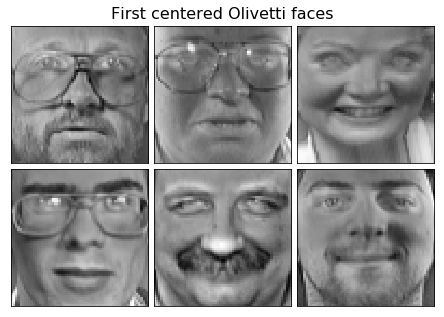

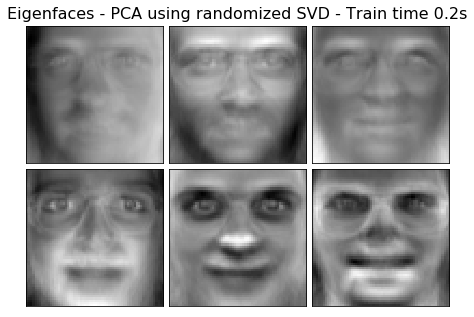

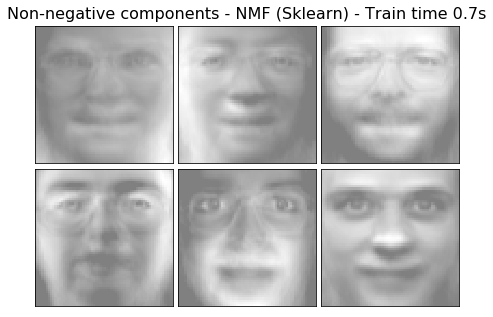

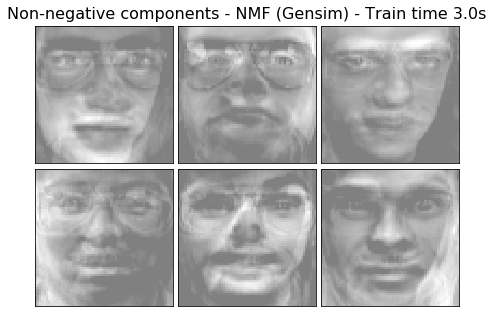

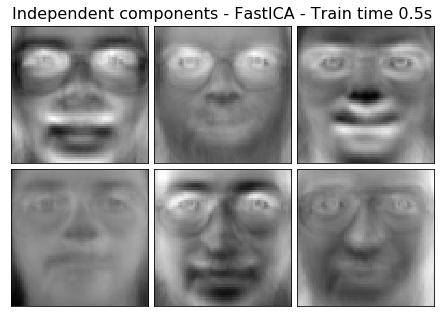

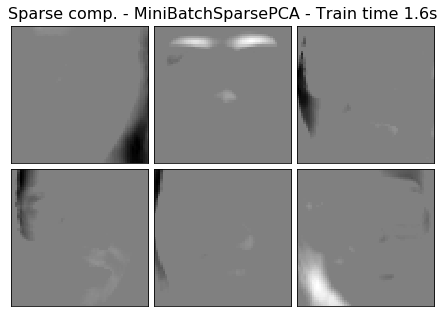

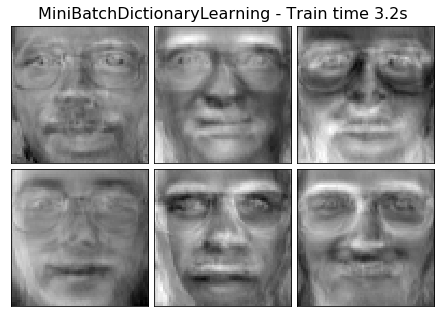

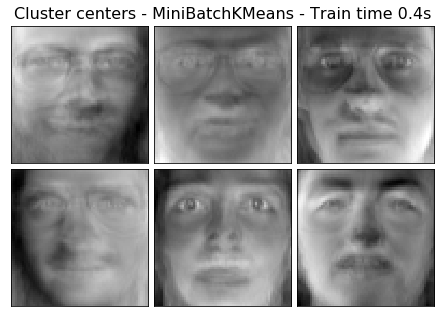

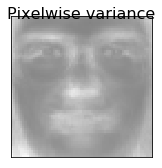

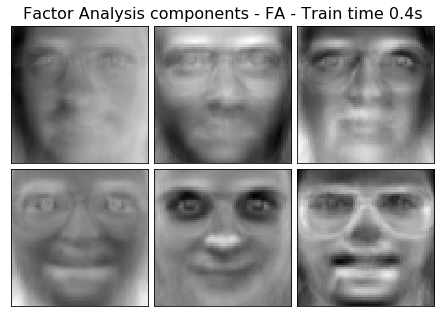

In [160]:
"""
============================
Faces dataset decompositions
============================

This example applies to :ref:`olivetti_faces` different unsupervised
matrix decomposition (dimension reduction) methods from the module
:py:mod:`sklearn.decomposition` (see the documentation chapter
:ref:`decompositions`) .

"""
print(__doc__)

# Authors: Vlad Niculae, Alexandre Gramfort
# License: BSD 3 clause

import logging
from time import time

from numpy.random import RandomState
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_olivetti_faces
from sklearn.cluster import MiniBatchKMeans
from sklearn import decomposition

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')
n_row, n_col = 2, 3
n_components = n_row * n_col
image_shape = (64, 64)
rng = RandomState(0)

# #############################################################################
# Load faces data
dataset = fetch_olivetti_faces(shuffle=True, random_state=rng)
faces = dataset.data

n_samples, n_features = faces.shape

# global centering
faces_centered = faces - faces.mean(axis=0)

# local centering
faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)

print("Dataset consists of %d faces" % n_samples)


def plot_gallery(title, images, n_col=n_col, n_row=n_row):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=plt.cm.gray,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

# #############################################################################
# List of the different estimators, whether to center and transpose the
# problem, and whether the transformer uses the clustering API.
estimators = [
    ('Eigenfaces - PCA using randomized SVD',
     decomposition.PCA(n_components=n_components, svd_solver='randomized',
                       whiten=True),
     True),

    ('Non-negative components - NMF (Sklearn)',
     decomposition.NMF(n_components=n_components, init='nndsvda', tol=5e-3),
     False),
    
    ('Non-negative components - NMF (Gensim)',
     NmfWrapper(
        chunksize=10,
        id2word={idx:idx for idx in range(faces.shape[1])},
        num_topics=n_components,
        minimum_probability=0
     ),
     False),

    ('Independent components - FastICA',
     decomposition.FastICA(n_components=n_components, whiten=True),
     True),

    ('Sparse comp. - MiniBatchSparsePCA',
     decomposition.MiniBatchSparsePCA(n_components=n_components, alpha=0.8,
                                      n_iter=100, batch_size=3,
                                      random_state=rng),
     True),

    ('MiniBatchDictionaryLearning',
        decomposition.MiniBatchDictionaryLearning(n_components=15, alpha=0.1,
                                                  n_iter=50, batch_size=3,
                                                  random_state=rng),
     True),

    ('Cluster centers - MiniBatchKMeans',
        MiniBatchKMeans(n_clusters=n_components, tol=1e-3, batch_size=20,
                        max_iter=50, random_state=rng),
     True),

    ('Factor Analysis components - FA',
     decomposition.FactorAnalysis(n_components=n_components, max_iter=2),
     True),
]


# #############################################################################
# Plot a sample of the input data

plot_gallery("First centered Olivetti faces", faces_centered[:n_components])

# #############################################################################
# Do the estimation and plot it

for name, estimator, center in estimators:
    print("Extracting the top %d %s..." % (n_components, name))
    t0 = time()
    data = faces
    if center:
        data = faces_centered
    estimator.fit(data)
    train_time = (time() - t0)
    print("done in %0.3fs" % train_time)
    if hasattr(estimator, 'cluster_centers_'):
        components_ = estimator.cluster_centers_
    else:
        components_ = estimator.components_

    # Plot an image representing the pixelwise variance provided by the
    # estimator e.g its noise_variance_ attribute. The Eigenfaces estimator,
    # via the PCA decomposition, also provides a scalar noise_variance_
    # (the mean of pixelwise variance) that cannot be displayed as an image
    # so we skip it.
    if (hasattr(estimator, 'noise_variance_') and
            estimator.noise_variance_.ndim > 0):  # Skip the Eigenfaces case
        plot_gallery("Pixelwise variance",
                     estimator.noise_variance_.reshape(1, -1), n_col=1,
                     n_row=1)
    plot_gallery('%s - Train time %.1fs' % (name, train_time),
                 components_[:n_components])

plt.show()

# Image of stars
### (For the sake of visualization of performance on sparse trainset)

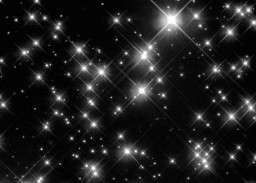

In [17]:
from PIL import Image
img = Image.open('stars_scaled.jpg').convert('L')
img

In [18]:
img_matrix = np.uint8(img.getdata()).reshape(img.size[::-1])
img_matrix.shape

(183, 256)

## Sklearn NMF

In [19]:
%%time

sklearn_nmf = SklearnNmf(n_components=10, tol=1e-5, max_iter=int(1e9))

W = sklearn_nmf.fit_transform(img_matrix)
H = sklearn_nmf.components_

CPU times: user 374 ms, sys: 560 ms, total: 934 ms
Wall time: 262 ms


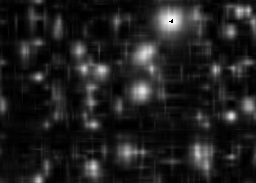

In [20]:
Image.fromarray(np.uint8(W.dot(H)), 'L')

## Gensim NMF

In [21]:
np.random.seed(42)

img_corpus = matutils.Dense2Corpus(img_matrix[np.random.choice(img_matrix.shape[0], img_matrix.shape[0], replace=False)].T)

In [22]:
%%time

import itertools

gensim_nmf = GensimNmf(
    img_corpus,
    chunksize=40,
    num_topics=10,
    passes=1,
    id2word={k: k for k in range(img_matrix.shape[1])},
    lambda_=1000,
    kappa=1,
    normalize=False
)

2018-08-20 22:15:22,726 : INFO : h_r_error: 17211892.5
2018-08-20 22:15:22,729 : INFO : h_r_error: 12284515.111163257
2018-08-20 22:15:22,731 : INFO : h_r_error: 11201387.638214733
2018-08-20 22:15:22,734 : INFO : h_r_error: 10815579.549704548
2018-08-20 22:15:22,738 : INFO : h_r_error: 10646539.06006998
2018-08-20 22:15:22,747 : INFO : h_r_error: 10558409.831047071
2018-08-20 22:15:22,755 : INFO : h_r_error: 10507775.272428757
2018-08-20 22:15:22,757 : INFO : h_r_error: 10475469.606854783
2018-08-20 22:15:22,759 : INFO : h_r_error: 10453925.335400445
2018-08-20 22:15:22,762 : INFO : h_r_error: 10439939.102116534
2018-08-20 22:15:22,784 : INFO : w_error: 10430366.610691467
2018-08-20 22:15:22,788 : INFO : w_error: 11466405.186009312
2018-08-20 22:15:22,791 : INFO : w_error: 10938537.274967317
2018-08-20 22:15:22,793 : INFO : w_error: 10835183.946454465
2018-08-20 22:15:22,799 : INFO : w_error: 10808896.588521175
2018-08-20 22:15:22,803 : INFO : w_error: 10800700.69189361
2018-08-20 22:

2018-08-20 22:15:23,774 : INFO : w_error: 2366899.5684030103
2018-08-20 22:15:23,780 : INFO : w_error: 2347964.180692087
2018-08-20 22:15:23,787 : INFO : w_error: 2332331.149509242
2018-08-20 22:15:23,791 : INFO : w_error: 2319290.024670701
2018-08-20 22:15:23,794 : INFO : w_error: 2308301.644607859
2018-08-20 22:15:23,811 : INFO : w_error: 2298998.176426708
2018-08-20 22:15:23,814 : INFO : w_error: 2291054.8383098356
2018-08-20 22:15:23,818 : INFO : w_error: 2284233.8267418565
2018-08-20 22:15:23,821 : INFO : w_error: 2278346.4815429775
2018-08-20 22:15:23,823 : INFO : w_error: 2273239.326070163
2018-08-20 22:15:23,824 : INFO : w_error: 2268800.1953844256
2018-08-20 22:15:23,826 : INFO : w_error: 2264918.837606525
2018-08-20 22:15:23,828 : INFO : w_error: 2261511.2618650706
2018-08-20 22:15:23,830 : INFO : w_error: 2258510.001427239
2018-08-20 22:15:23,831 : INFO : w_error: 2255858.510132532
2018-08-20 22:15:23,833 : INFO : w_error: 2253518.01968442
2018-08-20 22:15:23,834 : INFO : w_

CPU times: user 1.3 s, sys: 1.91 s, total: 3.22 s
Wall time: 1.63 s


In [23]:
W = gensim_nmf.get_topics().T
H = np.hstack(gensim_nmf[bow] for bow in matutils.Dense2Corpus(img_matrix.T))

2018-08-20 22:15:24,333 : INFO : h_r_error: 1641779.1711565189
2018-08-20 22:15:24,335 : INFO : h_r_error: 118028.68383364937
2018-08-20 22:15:24,337 : INFO : h_r_error: 105616.73503369163
2018-08-20 22:15:24,339 : INFO : h_r_error: 105376.48023111676
2018-08-20 22:15:24,344 : INFO : h_r_error: 105376.48023111676
2018-08-20 22:15:24,345 : INFO : h_r_error: 88296.81129174746
2018-08-20 22:15:24,347 : INFO : h_r_error: 75598.49700209008
2018-08-20 22:15:24,350 : INFO : h_r_error: 75202.00810070324
2018-08-20 22:15:24,352 : INFO : h_r_error: 75202.00810070324
2018-08-20 22:15:24,353 : INFO : h_r_error: 40896.39022296863
2018-08-20 22:15:24,354 : INFO : h_r_error: 32494.67090191547
2018-08-20 22:15:24,356 : INFO : h_r_error: 32239.868252556797
2018-08-20 22:15:24,366 : INFO : h_r_error: 32239.868252556797
2018-08-20 22:15:24,368 : INFO : h_r_error: 44930.159607806534
2018-08-20 22:15:24,370 : INFO : h_r_error: 36557.7492240496
2018-08-20 22:15:24,371 : INFO : h_r_error: 35312.9484972738
20

2018-08-20 22:15:24,658 : INFO : h_r_error: 134685.80489629053
2018-08-20 22:15:24,661 : INFO : h_r_error: 113538.95669792594
2018-08-20 22:15:24,665 : INFO : h_r_error: 113353.41144229252
2018-08-20 22:15:24,669 : INFO : h_r_error: 113353.41144229252
2018-08-20 22:15:24,671 : INFO : h_r_error: 122345.42442740352
2018-08-20 22:15:24,672 : INFO : h_r_error: 101206.04117840753
2018-08-20 22:15:24,673 : INFO : h_r_error: 100993.62587045786
2018-08-20 22:15:24,674 : INFO : h_r_error: 100993.62587045786
2018-08-20 22:15:24,676 : INFO : h_r_error: 116266.06525752878
2018-08-20 22:15:24,677 : INFO : h_r_error: 96812.1429100881
2018-08-20 22:15:24,683 : INFO : h_r_error: 96671.85729303533
2018-08-20 22:15:24,686 : INFO : h_r_error: 96671.85729303533
2018-08-20 22:15:24,687 : INFO : h_r_error: 124976.11247413699
2018-08-20 22:15:24,689 : INFO : h_r_error: 105696.72347766797
2018-08-20 22:15:24,690 : INFO : h_r_error: 105516.7395837665
2018-08-20 22:15:24,691 : INFO : h_r_error: 105516.739583766

2018-08-20 22:15:25,015 : INFO : h_r_error: 58344.200783367785
2018-08-20 22:15:25,020 : INFO : h_r_error: 56997.1979143896
2018-08-20 22:15:25,023 : INFO : h_r_error: 56864.86772938072
2018-08-20 22:15:25,025 : INFO : h_r_error: 56864.86772938072
2018-08-20 22:15:25,031 : INFO : h_r_error: 55804.84516396389
2018-08-20 22:15:25,032 : INFO : h_r_error: 49720.76312800324
2018-08-20 22:15:25,034 : INFO : h_r_error: 48669.3293093283
2018-08-20 22:15:25,036 : INFO : h_r_error: 48566.79973146436
2018-08-20 22:15:25,039 : INFO : h_r_error: 48566.79973146436
2018-08-20 22:15:25,042 : INFO : h_r_error: 50232.78247908833
2018-08-20 22:15:25,045 : INFO : h_r_error: 43460.18499959944
2018-08-20 22:15:25,047 : INFO : h_r_error: 42583.76639804095
2018-08-20 22:15:25,049 : INFO : h_r_error: 42583.76639804095
2018-08-20 22:15:25,051 : INFO : h_r_error: 70689.83802178742
2018-08-20 22:15:25,053 : INFO : h_r_error: 54799.329874802635
2018-08-20 22:15:25,057 : INFO : h_r_error: 53914.8316747843
2018-08-2

2018-08-20 22:15:25,356 : INFO : h_r_error: 123923.46378028487
2018-08-20 22:15:25,357 : INFO : h_r_error: 91401.7915719367
2018-08-20 22:15:25,359 : INFO : h_r_error: 85191.39582673303
2018-08-20 22:15:25,361 : INFO : h_r_error: 84532.90616743342
2018-08-20 22:15:25,364 : INFO : h_r_error: 84532.90616743342
2018-08-20 22:15:25,365 : INFO : h_r_error: 111957.92974291708
2018-08-20 22:15:25,367 : INFO : h_r_error: 90673.10717043538
2018-08-20 22:15:25,368 : INFO : h_r_error: 86795.48708018255
2018-08-20 22:15:25,370 : INFO : h_r_error: 86359.0193082306
2018-08-20 22:15:25,372 : INFO : h_r_error: 86359.0193082306
2018-08-20 22:15:25,374 : INFO : h_r_error: 78116.94232451699
2018-08-20 22:15:25,389 : INFO : h_r_error: 64864.185952766085
2018-08-20 22:15:25,403 : INFO : h_r_error: 62627.20138398043
2018-08-20 22:15:25,406 : INFO : h_r_error: 62387.88488623845
2018-08-20 22:15:25,417 : INFO : h_r_error: 62387.88488623845
2018-08-20 22:15:25,418 : INFO : h_r_error: 49500.7753928332
2018-08-2

2018-08-20 22:15:25,908 : INFO : h_r_error: 20608.810430887163
2018-08-20 22:15:25,910 : INFO : h_r_error: 20433.54257729559
2018-08-20 22:15:25,911 : INFO : h_r_error: 20400.741509122505
2018-08-20 22:15:25,913 : INFO : h_r_error: 20400.741509122505
2018-08-20 22:15:25,916 : INFO : h_r_error: 28200.31679054761
2018-08-20 22:15:25,919 : INFO : h_r_error: 23300.098733814248
2018-08-20 22:15:25,929 : INFO : h_r_error: 22137.1510942318
2018-08-20 22:15:25,931 : INFO : h_r_error: 21810.085864093246
2018-08-20 22:15:25,932 : INFO : h_r_error: 21775.213278946343
2018-08-20 22:15:25,934 : INFO : h_r_error: 21775.213278946343
2018-08-20 22:15:25,935 : INFO : h_r_error: 15260.366709589653
2018-08-20 22:15:25,936 : INFO : h_r_error: 11872.08315938859
2018-08-20 22:15:25,937 : INFO : h_r_error: 10908.905597899073
2018-08-20 22:15:25,938 : INFO : h_r_error: 10684.630020773682
2018-08-20 22:15:25,939 : INFO : h_r_error: 10651.271246929588
2018-08-20 22:15:25,941 : INFO : h_r_error: 10651.2712469295

2018-08-20 22:15:26,250 : INFO : h_r_error: 89193.15992567304
2018-08-20 22:15:26,251 : INFO : h_r_error: 82326.7193949022
2018-08-20 22:15:26,253 : INFO : h_r_error: 81654.10188430984
2018-08-20 22:15:26,254 : INFO : h_r_error: 81550.8364588384
2018-08-20 22:15:26,256 : INFO : h_r_error: 81550.8364588384
2018-08-20 22:15:26,258 : INFO : h_r_error: 195202.30314943343
2018-08-20 22:15:26,259 : INFO : h_r_error: 87377.33791727532
2018-08-20 22:15:26,261 : INFO : h_r_error: 80672.67496760779
2018-08-20 22:15:26,262 : INFO : h_r_error: 80479.76631168138
2018-08-20 22:15:26,268 : INFO : h_r_error: 80479.76631168138
2018-08-20 22:15:26,271 : INFO : h_r_error: 144824.23872960033
2018-08-20 22:15:26,272 : INFO : h_r_error: 55900.50694270172
2018-08-20 22:15:26,273 : INFO : h_r_error: 50456.945266342926
2018-08-20 22:15:26,275 : INFO : h_r_error: 50209.455574301464
2018-08-20 22:15:26,277 : INFO : h_r_error: 50209.455574301464
2018-08-20 22:15:26,278 : INFO : h_r_error: 120497.96569875091
2018-

2018-08-20 22:15:26,582 : INFO : h_r_error: 18959.722842143907
2018-08-20 22:15:26,583 : INFO : h_r_error: 83876.31226742358
2018-08-20 22:15:26,584 : INFO : h_r_error: 27066.441250717817
2018-08-20 22:15:26,586 : INFO : h_r_error: 23671.276967366928
2018-08-20 22:15:26,587 : INFO : h_r_error: 23588.035853516478
2018-08-20 22:15:26,590 : INFO : h_r_error: 23588.035853516478
2018-08-20 22:15:26,591 : INFO : h_r_error: 87851.09522030315
2018-08-20 22:15:26,593 : INFO : h_r_error: 36557.55519906569
2018-08-20 22:15:26,596 : INFO : h_r_error: 32920.158554937225
2018-08-20 22:15:26,605 : INFO : h_r_error: 32884.0633641823


### Reconstructed matrix:

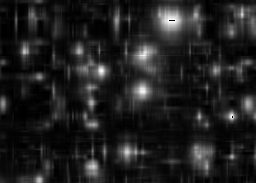

In [24]:
Image.fromarray(np.uint8(W.dot(H).T), 'L')

In [ ]:
class TestClass: